In [10]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import copy
from sklearn.cluster import KMeans

In [11]:
# HELPER FUNCTIONS

"""
Encode categorical variables and fill missing values with 0
"""
def encode_and_fill(df):
    s = (df.dtypes == 'object')
    object_cols = list(s[s].index)

    ordinal_encoder = OrdinalEncoder()
    label_df = df.copy()
    label_df[object_cols] = ordinal_encoder.fit_transform(df[object_cols])

    label_df = label_df.fillna(0)

    return label_df

"""
Replace groups of highly correlated features with their average values
"""
def avg_features(df):
    Xtraindf = copy.deepcopy(df)
    Xtraindf['Avg_min_temp_winter'] = (Xtraindf['january_min_temp'] + Xtraindf['february_min_temp'] + Xtraindf['march_min_temp'] + Xtraindf['april_min_temp'] + Xtraindf['october_min_temp'] + Xtraindf['november_min_temp'] + Xtraindf['december_min_temp'])/7
    Xtraindf['Avg_max_temp_winter'] = (Xtraindf['january_max_temp'] + Xtraindf['february_max_temp'] + Xtraindf['march_max_temp'] + Xtraindf['april_max_temp'] + Xtraindf['october_max_temp'] + Xtraindf['november_max_temp'] + Xtraindf['december_max_temp'])/7
    Xtraindf['Avg_temp_winter'] = (Xtraindf['january_avg_temp'] + Xtraindf['february_avg_temp'] + Xtraindf['march_avg_temp'] + Xtraindf['april_avg_temp'] + Xtraindf['october_avg_temp'] + Xtraindf['november_avg_temp'] + Xtraindf['december_avg_temp'])/7
    Xtraindf['Avg_min_temp_summer'] = (Xtraindf['may_min_temp'] + Xtraindf['june_min_temp'] + Xtraindf['july_min_temp'] + Xtraindf['august_min_temp'] + Xtraindf['september_min_temp'])/5 
    Xtraindf['Avg_max_temp_summer'] = (Xtraindf['may_max_temp'] + Xtraindf['june_max_temp'] + Xtraindf['july_max_temp'] + Xtraindf['august_max_temp'] + Xtraindf['september_max_temp'])/5
    Xtraindf['Avg_temp_summer'] = (Xtraindf['may_avg_temp'] + Xtraindf['june_avg_temp'] + Xtraindf['july_avg_temp'] + Xtraindf['august_avg_temp'] + Xtraindf['september_avg_temp'])/5 
    Xtraindf['Avg_days_below30F'] = (Xtraindf['days_below_30F'] + Xtraindf['days_below_20F'] + Xtraindf['days_below_10F'] + Xtraindf['days_below_0F'])/4
    return Xtraindf

"""
Create an k-means inertia plot for the given data
"""
def plot_inertia(X):
    # Inertia plots
    inertia = []
    for i in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
        model = KMeans(n_clusters = i)
        model.fit(X)
        inertia.append(model.inertia_)
    plt.plot(range(2,16), inertia)
    plt.title('Inertia Plot')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.show() 

"""
Perform k-means clustering on given data and add cluster labels to the DataFrame.
Return the fitted k-means model and the DataFrame wtih cluster labels.

Note: df must be the full DataFrame without the target value removed.
"""
def k_means(k, df):
    cluster_df = copy.deepcopy(df) # For adding cluster labels
    X_df = copy.deepcopy(df) # Features for training kmeans
    X_df = X_df.drop(columns=['site_eui', 'id'])

    # Drop categorical variables
    categorical_vars = ['Year_Factor', 'State_Factor', 'facility_type']
    X_df = X_df.drop(columns=categorical_vars)

    # Only consider the most important numerical features
    X_df = X_df[['floor_area', 'year_built', 'energy_star_rating']]

    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X_df)
    y_predict = kmeans.fit_predict(X_df)
    cluster_df['cluster'] = y_predict
    return kmeans, cluster_df

"""
Run RandomForest on each cluster of the dataset. Return a list of scores.
Note: df must be the full DataFrame including target values and a 'cluster' feature.
"""
def rf_cluster(df, num_clusters):
    rf_scores = [] # List of random forest scores

    # Run random forest on each cluster
    for i in range(num_clusters):
        # Isolate current cluster
        cluster_df = df.loc[df['cluster'] == i]
        y = np.array(cluster_df['site_eui']).reshape(-1,1)
        X = cluster_df.drop(columns=['site_eui', 'id', 'cluster'])
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

        # Run random forest
        rf = RandomForestRegressor(n_estimators=40, max_depth=8)
        rf.fit(X_train, y_train.ravel())
        y_pred = rf.predict(X_test)
        score = rf.score(X_test, y_test)
        rf_scores.append(score)

    return rf_scores


In [12]:
### SPLIT DATA BASED ON BUILDING TYPE ###

train_df = pd.read_csv('train.csv')

# Separate data for commercial and residential buildings
com_train_df = train_df.loc[train_df['building_class'] == 'Commercial']
res_train_df = train_df.loc[train_df['building_class'] == 'Residential']
com_train_df = com_train_df.drop(columns=['building_class'])
res_train_df = res_train_df.drop(columns=['building_class'])

# Encode and fill, avg features
com_train_df = encode_and_fill(com_train_df)
com_train_df = avg_features(com_train_df)
res_train_df = encode_and_fill(res_train_df)
res_train_df = avg_features(res_train_df)

y_com_train = np.array(com_train_df['site_eui']).reshape(-1,1)
X_com_train = com_train_df.drop(columns=['site_eui', 'id'])
y_res_train = np.array(res_train_df['site_eui']).reshape(-1,1)
X_res_train = res_train_df.drop(columns=['site_eui', 'id'])



/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

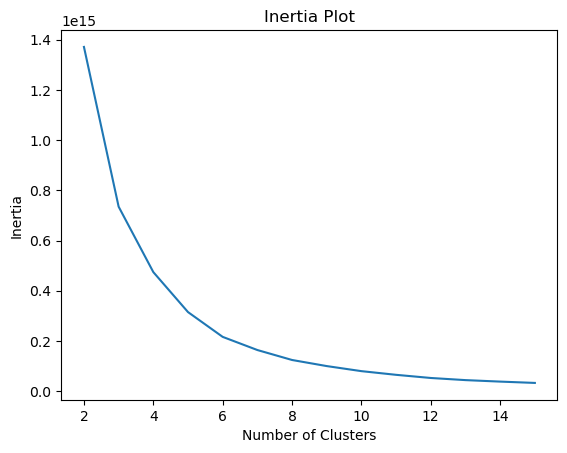

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

RF scores with 2 clusters:
[0.4501212061215729, 0.6095072786428211]

RF scores with 3 clusters:
[0.40234589232591844, 0.6074213118121206, 0.5911344562622275]

RF scores with 4 clusters:
[0.40959151318717657, 0.41072319098138355, 0.5942691489687155, 0.5093678304177356]

RF scores with 5 clusters:
[0.3887997729779995, 0.08563364784041883, 0.7953924674489765, 0.5363066528506502, 0.609055474748895]

RF scores with 6 clusters:
[0.39237249888841164, 0.41683459108322307, 0.6670948826702033, 0.5869112830467498, 0.3805621232455061, 0.3920908142234114]

RF scores with 7 clusters:
[0.3422448464107811, 0.30144249523278466, 0.5673290334620726, 0.5181226929520077, 0.49018393415448325, -0.3386414274231573, 0.5636781507669385]

RF scores with 8 clusters:
[0.3608561289886344, 0.4390565828438149, 0.5660454162649644, 0.6589332160128785, 0.5323798467888259, 0.38003608630222274, 0.43696049548494176, 0.5769557692394195]



In [13]:
### KMEANS FOR COMMERCIAL ###

plot_inertia(X_com_train)

# Dictionary with num_clusters as keys and rf_score lists as values
rf_scores_com = dict()

# Run kmeans and random forest
for k in range(2,9):
    kmeans_model, com_df_clus = k_means(k,com_train_df)
    rf_scores = rf_cluster(com_df_clus,k)
    rf_scores_com[k] = rf_scores

for k in rf_scores_com.keys():
    print("RF scores with", k, "clusters:")
    print(rf_scores_com[k])
    print()

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

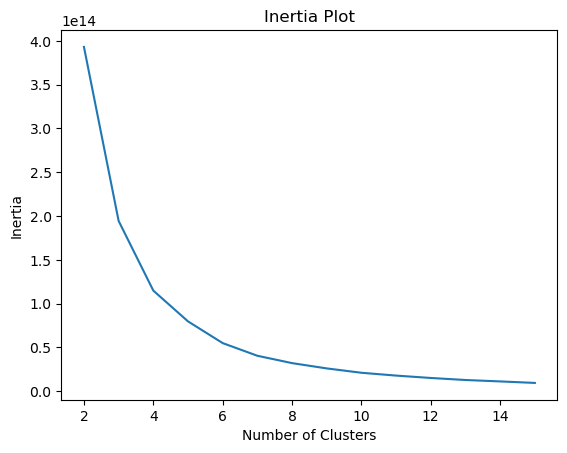

/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/jren/miniconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to

RF scores with 2 clusters:
[0.40030236726374324, 0.6727084076839515]

RF scores with 3 clusters:
[0.4114519023575498, 0.6207158818659522, 0.6463024488878997]

RF scores with 4 clusters:
[0.41213391299778435, 0.4754680213844853, 0.6093565814348425, 0.5818665075039087]

RF scores with 5 clusters:
[0.43568784215818035, 0.5020943788288739, 0.6861396173545035, 0.5516560440717098, -0.23888269774329363]

RF scores with 6 clusters:
[0.4259684216528712, 0.6274341392339648, 0.6094468819034489, 0.38667504431019617, 0.3416703076154922, 0.5386667395852949]

RF scores with 7 clusters:
[0.3809374361541641, 0.859818531395049, 0.4718615427671796, 0.6025260156281116, 0.4566107164478489, 0.6183644350453118, 0.5579753114831874]

RF scores with 8 clusters:
[0.32319762318019774, 0.5275712531178771, 0.4565598433124767, 0.6102403621303283, 0.7416157095584097, 0.4142131916252566, 0.5435624354932579, -3.900254528197454]



In [14]:
### KMEANS FOR RESIDENTIAL ###

plot_inertia(X_res_train)

# Dictionary with num_clusters as keys and rf_score lists as values
rf_scores_res = dict()

# Run kmeans and random forest
for k in range(2,9):
    kmeans_model, com_df_clus = k_means(k,com_train_df)
    rf_scores = rf_cluster(com_df_clus,k)
    rf_scores_res[k] = rf_scores

for k in rf_scores_res.keys():
    print("RF scores with", k, "clusters:")
    print(rf_scores_res[k])
    print()